### import modules

In [1]:
import pickle

import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel as nib

import bvbabel 

import os
from os.path import join, exists, split
import sys
import time
import urllib.request
import copy
import warnings
from tqdm import tqdm
from pprint import pprint
warnings.filterwarnings('ignore')

import glmsingle
from glmsingle.glmsingle import GLM_single

# note: the fracridge repository is also necessary to run this code
# for example, you could do:
#      git clone https://github.com/nrdg/fracridge.git



Set functions to quickly make the design matrixes 

In [2]:
def load_run_to_df(timing_files_dir, pp, currun):
    """load in mat file, parse and return dataframe"""

    # load the matfile of timings for this run
    mat = scipy.io.loadmat(join(timing_files_dir, str(pp), tonotopy_run_fn(currun)))

    # create dataframe for all the pulses
    df = pd.DataFrame({'pulse': mat['pulsez'][0,:],
                       'timing': mat['pulsez'][1,:]})

    # set conditions and timings temp df
    temp_df = pd.DataFrame({'timing': mat['timingz'][0,:],
                            'block' : mat['conditions'][0,:],
                            'freq'  : mat['conditions'][1,:],
                            'isgap' : mat['conditions'][2,:],
                            'seqorder' : mat['conditions'][3,:],
                            'trialblock' : mat['conditions'][4,:]})

    # merge the two together
    df = pd.merge(df, temp_df, how='left', on=['timing'])
    return(df)


def create_design_mat(df, ffs):
    """input dataframe and convert to onehot encoding in some desired order"""

    # create empty matrix of correct size
    zero_array = np.zeros([len(df),len(ffs)]) # create zeros array in shape of pulses X nr_freqs
    design_mat = pd.DataFrame(zero_array, columns=ffs)    # create design matrix dataframe

    # put in the 1 hot encoding
    for frq in range(len(df['freq'])):
        frq_val = df['freq'][frq]

        # check if the value is nan
        if not np.isnan(frq_val):
            design_mat.at[frq, frq_val] = 1

    return(design_mat.to_numpy())

Also, an implementation to read mask files in Python, this function can be removed in the feature since it will be added to bvbabel in the feature

In [3]:
"""Read, write, create Brainvoyager MSK file format."""

import struct
import numpy as np

# =============================================================================
def read_msk(filename):
    """Read Brainvoyager MSK file.

    Parameters
    ----------
    filename : string
        Path to file.

    Returns
    -------
    header : dictionary
        Pre-data header.
    data : 3D numpy.array
        Image data.

    """
    header = dict()
    with open(filename, 'rb') as f:
        
        # Expected binary data: short int (2 bytes)
        data, = struct.unpack('<h', f.read(2))
        header["VTC resolution relative to VMR (1, 2, or 3)"] = data
        
        # Expected binary data: short int (2 bytes)
        data, = struct.unpack('<h', f.read(2))
        header["XStart"] = data
        data, = struct.unpack('<h', f.read(2))
        header["XEnd"] = data
        data, = struct.unpack('<h', f.read(2))
        header["YStart"] = data
        data, = struct.unpack('<h', f.read(2))
        header["YEnd"] = data
        data, = struct.unpack('<h', f.read(2))
        header["ZStart"] = data
        data, = struct.unpack('<h', f.read(2))
        header["ZEnd"] = data

        # Prepare dimensions of VTC data array
        VTC_resolution = header["VTC resolution relative to VMR (1, 2, or 3)"]
        DimX = (header["XEnd"] - header["XStart"]) // VTC_resolution
        DimY = (header["YEnd"] - header["YStart"]) // VTC_resolution
        DimZ = (header["ZEnd"] - header["ZStart"]) // VTC_resolution
        
        # ---------------------------------------------------------------------
        # Read MSK data
        # ---------------------------------------------------------------------
        
        data_img = np.zeros(DimZ * DimY * DimX)
        
        for i in range(data_img.size):
            data_img[i], = struct.unpack('<B', f.read(1))
        
        data_img = np.reshape(data_img, (DimZ, DimY, DimX))
        data_img = np.transpose(data_img, (0, 2, 1))  # BV to Tal
        data_img = data_img[::-1, ::-1, ::-1]  # Flip BV axes

    return header, data_img


# =============================================================================
def write_msk(filename, header, data_img):
    """Protocol to write Brainvoyager MSK file.

    Parameters
    ----------
    filename : string
        Path to file.
    header : dictionary
        Pre-data header.
    data_img : 3D numpy.array
        Image data.

    """
    with open(filename, 'wb') as f:

        # Expected binary data: short int (2 bytes)
        data = header["VTC resolution relative to VMR (1, 2, or 3)"]
        f.write(struct.pack('<h', data))

        data = header["XStart"]
        f.write(struct.pack('<h', data))
        data = header["XEnd"]
        f.write(struct.pack('<h', data))
        data = header["YStart"]
        f.write(struct.pack('<h', data))
        data = header["YEnd"]
        f.write(struct.pack('<h', data))
        data = header["ZStart"]
        f.write(struct.pack('<h', data))
        data = header["ZEnd"]
        f.write(struct.pack('<h', data))

        # ---------------------------------------------------------------------
        # Write MSK data
        # ---------------------------------------------------------------------
        data_img = data_img[::-1, ::-1, ::-1]  # Flip BV axes
        data_img = np.transpose(data_img, (0, 2, 1))  # Tal to BV
        data_img = np.reshape(data_img, data_img.size)

        for i in range(data_img.size):
            f.write(struct.pack('<B', int(data_img[i])))

### Settings
first we set the directory structure from which we load

In [5]:
# pp settings
pp = 2

# set home dir
homedir = '/media/jorvhar/Data1/MRIData/PreProc/S0{}_SES1'.format(pp)
foldername = 'glmsingle'

# set save directory
datadir = join(homedir,foldername,'data')
os.makedirs(datadir,exist_ok=True) # create if doesnt exist

# create directory for saving outputs
outputdir = join(homedir,foldername,'outputs')
os.makedirs(outputdir,exist_ok=True)

# make directory for numpy vtc savings
numpydir = join(homedir,foldername,'numpyvtc')
os.makedirs(numpydir,exist_ok=True)

# load mat files from directory
timing_files_dir = '/media/jorvhar/Data1/MRIData/timing data/data'
tonotopy_settings_fn = '{}_settings_tonotopy.mat'.format(pp)
tonotopy_run_fn = lambda r : '{}-r{}-tonotopy.mat'.format(pp, r) 

# load settings mat
settings_mat = scipy.io.loadmat(join(timing_files_dir, str(pp), tonotopy_settings_fn))

Also set the general settings, where possible taken from the settings mat file

In [7]:
# get settings from stimuli settings mat file
stimdur = settings_mat['cfg']['stim_len'].any().item()   # ['TR']  ['stim_len']
tr = settings_mat['cfg']['TR'].any().item()
nconds = settings_mat['cfg']['num_freqs'].any().item() #same as nblocks
ffs_oct = np.squeeze(settings_mat['cfg']['freq_array'].any())
ffs = 2**ffs_oct
nr_runs = 6
    # stimdur = tr
    
# settings for file namings
vtc_fn_run = lambda run : 'S0{}_SES1_run{}_FMR_SCSTBL_3DMCTS_THPGLMF7c_TOPUP.vtc'.format(pp, run)
msk_fn = 'brainmask.msk'

## create a dataframe with coding information

In [8]:
# EITHER IMPLEMENT THE MASKING,
# OR SET THE ADVANCED REGISTRATION SO THAT WE HAVE THE GREY MATTER - THIS WILL FREE A LOT OF SPACE

In [14]:
import vtc

_, img = vtc.read_vtc_msk(fullpath, mskimg)

NameError: name 'fullpath' is not defined

In [21]:
# read mask
_, mskimg = read_msk(join(homedir, msk_fn))

# loop over runs and put all runs in dict
dfs = {}
data = []
datahdr = {}
design = []

# get timings
start_time = time.time()

for currun in np.arange(1,nr_runs+1):
    
    if not exists(join(numpydir, '11run1_vtc.npy')):
        # load vtc file
        vtc_fn = join(homedir,vtc_fn_run(currun))
        print(f'loading {vtc_fn}')
        datahdr[currun], vtc_img = vtc.read_vtc_msk(vtc_fn, mskimg)
        data.append(vtc_img) 
#         data.append(vtc_img[np.where(mskimg)]) ## - if we want to mask everything
        print(f'done, cleaning up \n')
        del vtc_img
    else:
        # load vtcs from numpy pickle
        data.append(np.load(join(numpydir, f'run{currun}_vtc.npy')))    
        print(f'{numpydir} directory found, loading run{currun}_vtc.npy from memory')
        # load data header from pickle
        datahdr = pickle.load( open( join(numpydir, 'datahdr.p'), "rb" ) )

    # put info and design in dataframe and array
    dfs[currun] = load_run_to_df(timing_files_dir, pp, currun)
    design.append(create_design_mat(dfs[currun], ffs_oct))
    
elapsed_time = time.time() - start_time
print('\telapsed time: ', f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}')

loading /media/jorvhar/Data1/MRIData/PreProc/S02_SES1/S02_SES1_run1_FMR_SCSTBL_3DMCTS_THPGLMF7c_TOPUP.vtc
done, cleaning up 

loading /media/jorvhar/Data1/MRIData/PreProc/S02_SES1/S02_SES1_run2_FMR_SCSTBL_3DMCTS_THPGLMF7c_TOPUP.vtc
done, cleaning up 

loading /media/jorvhar/Data1/MRIData/PreProc/S02_SES1/S02_SES1_run3_FMR_SCSTBL_3DMCTS_THPGLMF7c_TOPUP.vtc
done, cleaning up 

loading /media/jorvhar/Data1/MRIData/PreProc/S02_SES1/S02_SES1_run4_FMR_SCSTBL_3DMCTS_THPGLMF7c_TOPUP.vtc
done, cleaning up 

loading /media/jorvhar/Data1/MRIData/PreProc/S02_SES1/S02_SES1_run5_FMR_SCSTBL_3DMCTS_THPGLMF7c_TOPUP.vtc
done, cleaning up 

loading /media/jorvhar/Data1/MRIData/PreProc/S02_SES1/S02_SES1_run6_FMR_SCSTBL_3DMCTS_THPGLMF7c_TOPUP.vtc
done, cleaning up 

	elapsed time:  00:01:57


Because `read_vtc` loops over the data sequentially it can be somewhat slow, so for now we loop over the runs and save the run vtcs as numpy.

- with new function not needed anymore

In [9]:
# save the numpy arrays in the folder so that we can load them a lot faster then vtc read
for currun in np.arange(1,nr_runs+1):
    np.save(join(numpydir, f'run{currun}_vtc.npy'), data[currun-1])

# also save the datahdr 
pickle.dump( datahdr, open( join(numpydir, 'datahdr.p'), 'wb') )

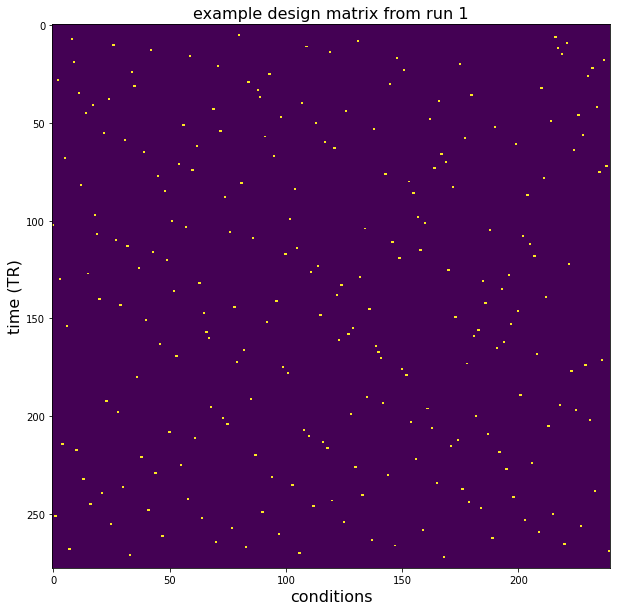

In [22]:
# plot example design matrix from run 1
plt.figure(figsize=(10,10))
plt.imshow(design[2],aspect='auto',interpolation='none')
plt.title('example design matrix from run 1',fontsize=16)
plt.xlabel('conditions',fontsize=16)
plt.ylabel('time (TR)',fontsize=16);

In [23]:
# print some relevant metadata
print(f'Data has {len(data)} runs\n')
print(f'There are {nconds} total blocks in runs 1-{len(data)}\n')
print(f'Shape of data from each run is: {data[0].shape}\n')
print(f'There are {np.sum(mskimg)} voxels in the included visual ROI')

Data has 6 runs

There are 240 total blocks in runs 1-6

Shape of data from each run is: (1000643, 278)

There are 1000643.0 voxels in the included visual ROI


### calculate twogamma hrf

In [131]:
import numpy as np
from scipy.stats import gamma

def gammapdf(x, a, scale):
    return gamma.pdf(x, a, scale=scale)

def hrf(shape, sfrq=1/16, pttp=5, nttp=15, pnr=6, ons=0, pdsp=1, ndsp=1, s=None, d=0, nt='area'):
    # argument check
    d = round(d) if 0 <= d <= 2 else 0
    ndsp = 1 if ndsp <= 0 else ndsp
    pdsp = 1 if pdsp <= 0 else pdsp
    ons = 0 if ons < -5 or ons > 5 else ons
    pnr = 6 if pnr < 1 else pnr
    nttp = 15 if nttp < 1 or nttp > 30 else nttp
    pttp = 5 if pttp < 1 or pttp > 30 else pttp
    sfrq = 1/16 if sfrq > 5 else sfrq if sfrq >= 0.001 else 0.001

    if s is None:
        s = np.arange(0,(ons + 2 * (nttp + 1)) - ons,sfrq)

    h = np.zeros((len(s), d + 1))
    if shape == 'boynton':
        h[:, 0] = gammapdf(s, pttp + 1, pdsp)
        if d > 0:
            h[:, 1] = h[:, 0] - gammapdf(s + 1, pttp + 1, pdsp)
            hi = np.where(h[:, 1] != 0)
            h[hi, 1] = h[hi, 1] - (np.linalg.pinv(h[hi, 0].T @ h[hi, 0]) @ h[hi, 0].T @ h[hi, 1]).T @ h[hi, 0].T
            if d > 1:
                h[:, 2] = h[:, 0] - gammapdf(s, pttp + 1, pdsp / 1.01)
                hi = np.where(h[:, 2] != 0)
                h[hi, 2] = h[hi, 2] - (np.linalg.pinv(h[hi, [0, 1]].T @ h[hi, [0, 1]]) @ h[hi, [0, 1]].T @ h[hi, 2]).T @ h[hi, [0, 1]].T
    elif shape == 'twogamma':
        h[:, 0] = gammapdf(s, pttp + 1, pdsp) - gammapdf(s, nttp + 1, ndsp) / pnr
        if d > 0:
            h[:, 1] = h[:, 0] - (gammapdf(s - 1, pttp + 1, pdsp) - gammapdf(s - 1, nttp + 1, ndsp) / pnr)
            hi = np.where(h[:, 1] != 0)
            h[hi, 1] = h[hi, 1] - (np.linalg.pinv(h[hi, 0].T @ h[hi, 0]) @ h[hi, 0].T @ h[hi, 1]).T @ h[hi, 0].T
            if d > 1:
                h[:, 2] = (h[:, 0] - (gammapdf(s, (pttp + 1) / 1.01, pdsp / 1.01) - gammapdf(s, nttp + 1, ndsp) / pnr)) / 0.01
    return h, s

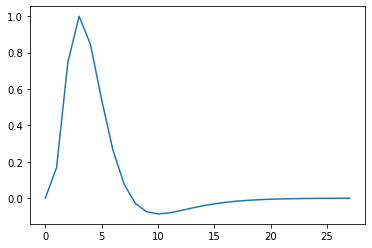

In [138]:
plt.plot(getcanonicalhrf(stimdur, tr))

In [121]:
h, s = hrf('twogamma', sfrq=tr, pttp=4, ons=0, nttp=16, pnr=6, pdsp=1, ndsp=1)

### GLM-Single settings
then we can set the glmsingle options, note that the options in `glmsingle_obj.params` are all changeable parameters (can play around with pcR2cutoff etc if output seems off)

In [ ]:
opt = dict()

# set important fields for completeness (but these would be enabled by default)
opt['wantlibrary'] = 0     # setting for using a canonical HRF
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk
opt['wantfileoutputs'] = [1,1,1,1]
opt['wantmemoryoutputs'] = [0,0,0,1]
opt['chunklen'] = 5000
#opt['wanthdf5'] = True

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmsingle_obj = GLM_single(opt)

# visualize all the hyperparameters
pprint(glmsingle_obj.params)

#<data> - can be [x y z , t] or [x , t] -- for masked data


In [ ]:
#          <xvalscheme> (optional) is a list of lists or list of run indices,
#          indicating the cross-validation scheme. For example, if we have 8
#          runs, we could use [[1, 2], [3, 4], [5, 6], [7, 8]] which indicates
#          to do 4 folds of cross-validation, first holding out the 1st and 2nd
#          runs, then the 3rd and 4th runs, etc.
#          Default: [[1], [2], [3], ... [n]] where n is the number of runs.

In [ ]:
# this example saves output files to the folder  "example2outputs/GLMsingle"
# if these outputs don't already exist, we will perform the time-consuming call to GLMsingle;
# otherwise, we will just load from disk.

start_time = time.time()

if not exists(join(outputdir,'TYPEA_ONOFF.npy')):

    print(f'running GLMsingle...')
    
    # run GLMsingle
    results_glmsingle = glmsingle_obj.fit(
       design,
       data,
       stimdur,
       tr,
       outputdir=outputdir)
    
    # we assign outputs of GLMsingle to the "results_glmsingle" variable.
    # note that results_glmsingle['typea'] contains GLM estimates from an ONOFF model,
    # where all images are treated as the same condition. these estimates
    # could be potentially used to find cortical areas that respond to
    # visual stimuli. we want to compare beta weights between conditions
    # therefore we are not going to include the ONOFF betas in any analyses of 
    # voxel reliability
    
else:
    print(f'loading existing GLMsingle outputs from directory:\n\t{outputdir}')
    
    # load existing file outputs if they exist
    results_glmsingle = dict()
    results_glmsingle['typea'] = np.load(join(outputdir,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
    results_glmsingle['typeb'] = np.load(join(outputdir,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
    results_glmsingle['typec'] = np.load(join(outputdir,'TYPEC_FITHRF_GLMDENOISE.npy'),allow_pickle=True).item()
    results_glmsingle['typed'] = np.load(join(outputdir,'TYPED_FITHRF_GLMDENOISE_RR.npy'),allow_pickle=True).item()

elapsed_time = time.time() - start_time

print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)

In [ ]:
## OUTPUTS

# the outputs of GLMsingle are formally documented in its
# header. here, we highlight a few of the more important outputs:

# R2 -> is model accuracy expressed in terms of R^2 (percentage).

# betasmd -> is the full set of single-trial beta weights (X x Y x Z x
# TRIALS). beta weights are arranged in chronological order.

# HRFindex -> is the 1-index of the best fit HRF. HRFs can be recovered
# with getcanonicalHRFlibrary(stimdur,tr)

# FRACvalue -> is the fractional ridge regression regularization level
# chosen for each voxel. values closer to 1 mean less regularization.

### Plotting GLM-Single outputs

In [ ]:
# we are going to plot several outputs from the FIT_HRF_GLMdenoise_RR GLM,
# which contains the full set of GLMsingle optimizations.

# we will plot betas, R2, optimal HRF indices, and the voxel frac values
plot_fields = ['betasmd','R2','HRFindex','FRACvalue']
colormaps = ['RdBu_r','hot','jet','copper']
clims = [[-5,5],[0,85],[0,20],[0,1]]

plt.figure(figsize=(12,8))

for i in range(len(plot_fields)):
    
    plt.subplot(2,2,i+1)
    
    if i == 0:
        # when plotting betas, for simplicity just average across all image presentations
        # this will yield a summary of whether voxels tend to increase or decrease their 
        # activity in response to the experimental stimuli (similar to outputs from 
        # an ONOFF GLM)
        plot_data = np.nanmean(np.squeeze(results_glmsingle['typed'][plot_fields[i]]),2)
        titlestr = 'average GLM betas (750 stimuli)'
    
    else:
        # plot all other voxel-wise metrics as outputted from GLMsingle
        plot_data = np.squeeze(results_glmsingle['typed'][plot_fields[i]].reshape(xyz))
        titlestr = plot_fields[i]
    
    plt.imshow(plot_data,cmap=colormaps[i],clim=clims[i])
    plt.colorbar()
    plt.title(titlestr)
    plt.axis(False)



## Comparing GLM-Single to baseline
as a quick check to see if everything has gone as expected we want to compare to a baseline GLM approach

In [ ]:
# output directory for baseline GLM
outputdir_baseline = join(outputdir,'GLMbaseline')

# we will run this baseline GLM by changing the default settings in GLMsingle 
# contained within the "opt" structure.
opt = dict() 

# turn off optimizations 
opt['wantlibrary'] = 0 # switch off HRF fitting
opt['wantglmdenoise'] = 0 # switch off GLMdenoise
opt['wantfracridge'] = 0 # switch off ridge regression


# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk...
# the first two indices are the ON-OFF GLM and the baseline single-trial GLM. 
# no need to save the third (+ GLMdenoise) and fourth (+ fracridge) outputs
# since they will not even be computed
opt['wantmemoryoutputs'] = [1,1,0,0] 
opt['wantfileoutputs'] = [1,1,0,0]

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmbaseline_obj = GLM_single(opt)

# visualize the hyperparameters, including the modified baseline opts
pprint(glmbaseline_obj.params)


# tic
start_time = time.time()

# if these outputs don't already exist, we will perform the call to
# GLMsingle; otherwise, we will just load from disk.
if not exists(outputdir_baseline):
    
    print(f'running GLMsingle...')

    # run GLMsingle, fitting the baseline GLM
    results_assumehrf = glmbaseline_obj.fit(
       design,
       data,
       stimdur,
       tr,
       outputdir=outputdir_baseline)
    
else:
    
    print(f'loading existing GLMsingle outputs from directory:\n\t{outputdir_glmsingle}')
    
    results_assumehrf = dict()
    results_assumehrf['typea'] = np.load(join(outputdir_baseline,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
    results_assumehrf['typeb'] = np.load(join(outputdir_baseline,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
    
    # note that even though we are loading TYPEB_FITHRF betas, HRF fitting
    # has been turned off and this struct field will thus contain the
    # outputs of a GLM fit using the canonical HRF.
    
elapsed_time = time.time() - start_time
print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)



In [ ]:


# create dictionary containing the GLM betas from the four different models we will compare.
# note that the "assume hrf" betas come from the "typeb" field of our baseline GLM
# (with HRF fitting turned off), and that the "fit hrf" betas also come from 
# the "typeb" field of the GLM that ran with all default GLMsingle routines
# enabled

models = dict()
models['assumehrf'] = results_assumehrf['typeb']['betasmd'].reshape(xyz + (750,))
models['fithrf'] = results_glmsingle['typeb']['betasmd']
models['fithrf_glmdenoise'] = results_glmsingle['typec']['betasmd']
models['fithrf_glmdenoise_rr'] = results_glmsingle['typed']['betasmd']



In [ ]:
empty_glmsinglebeta = np.zeros([data[0].shape[0], data[0].shape[1], data[0].shape[2], 1440])
empty_glmsinglebeta[np.where(mskimg)] = results_glmsingle['typed'][plot_fields[0]]


In [ ]:
empty_glmsinglebeta.shape

In [ ]:
plot_data = np.nanmean(np.squeeze(empty_glmsinglebeta),3).astype(float)


In [ ]:
# the outputs of GLMsingle are formally documented in its
# header. here, we highlight a few of the more important outputs:

# R2 -> is model accuracy expressed in terms of R^2 (percentage).

# betasmd -> is the full set of single-trial beta weights (X x Y x Z x
# TRIALS). beta weights are arranged in chronological order.

# HRFindex -> is the 1-index of the best fit HRF. HRFs can be recovered
# with getcanonicalHRFlibrary(stimdur,tr)

# FRACvalue -> is the fractional ridge regression regularization level
# chosen for each voxel. values closer to 1 mean less regularization.
#Plot a slice of brain showing GLMsingle outputs
# we are going to plot several outputs from the FIT_HRF_GLMdenoise_RR GLM,
# which contains the full set of GLMsingle optimizations.

# we will plot betas, R2, optimal HRF indices, and the voxel frac values
plot_fields = ['betasmd','R2','HRFindex','FRACvalue']
colormaps = ['RdBu_r','hot','jet','copper']
clims = [[-5,5],[0,85],[0,20],[0,1]]

meanvol = np.squeeze(np.mean(empty_betas.reshape(vtc_img.shape),3))
brainmask = meanvol > 275

plt.figure(figsize=(12,8))

for i in range(len(plot_fields)):
    
    plt.subplot(2,2,i+1)
    
    if i == 0:
        # when plotting betas, for simplicity just average across all image presentations
        # this will yield a summary of whether voxels tend to increase or decrease their 
        # activity in response to the experimental stimuli (similar to outputs from 
        # an ONOFF GLM)
        plot_data = np.nanmean(np.squeeze(empty_glmsinglebeta),3).astype(float)
        titlestr = 'average GLM betas (localizer runs 1-4)'
    
    else:
        # plot all other voxel-wise metrics as outputted from GLMsingle
        plot_data = np.squeeze(results_glmsingle['typed'][plot_fields[i]].reshape(xyz)).astype(float)
        titlestr = plot_fields[i]
    
    plot_data[~brainmask] = np.nan # remove values outside the brain for visualization purposes
    plt.imshow(plot_data[:,5:-5,20],cmap=colormaps[i],clim=clims[i])
    plt.colorbar()
    plt.title(titlestr)
    plt.axis(False)

In [ ]:
print(123)


In [ ]:
### PLAYGROUND TO INDEX MASK IMAGES

# mask the vtcimge with the mask
masked_vtc = vtcimg[np.where(mskimg)]

# we can then reimport the image back by doing
empty_betas = np.zeros(vtcimg.shape)
empty_betas[np.where(mskimg)] = masked_vtc

# to check
plt.imshow(empty_betas[:,:,10,40])